In [131]:
# Importing necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import keras 
from keras.utils import np_utils
import keras.models as models, Sequential
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split 
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

### Dataset: Load & Explore

In [132]:
# Load the dataset
from _pickle import load, dump
Xd = load(open("RML2016.10b.dat", 'rb'), encoding='latin1')

In [133]:
# Prepare the data into an appropriate format
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))

X = np.vstack(X)

In [134]:
# Print varoius aspects related to the Dataset (X)
print(f'Shape of X is: {X.shape}') 
print(f'Number of modulation schemes is: {len(mods)}, and number of SNRs ratio is: {len(snrs)}')
print(f'Number of signals per a single combination of (modulation, SNR): {len(list(Xd.values())[0])}')
print(f'Total number of received signals: {len(X)}')
print(f"Moulations Types: {mods}")
print(f"Induced SNRs: {snrs}")

Shape of X is: (1200000, 2, 128)
Number of modulation schemes is: 10, and number of SNRs ratio is: 20
Number of signals per a single combination of (modulation, SNR): 6000
Total number of received signals: 1200000
Moulations Types: ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Induced SNRs: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


Therefore, this Dataset have 10 different types of modulation schemes. Each modulation schemes have 20 different SNRs ratios. In total, we have 1,200,000 signals: 6000 signals/(Modulation,SNR). Moreover, for each signal of these 1,200,000, we have a real component & a complex component. And we will only investegate PSK & QAM moodulation schemes. 

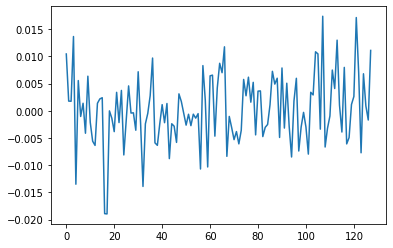

In [135]:
# plot of different received symbols
def signal_plotter(signal_number, complex_component):
    time = [x for x in range(128)]
    plt.plot(time, list(X[signal_number][complex_component]))  

signal_plotter(15031, 0) 

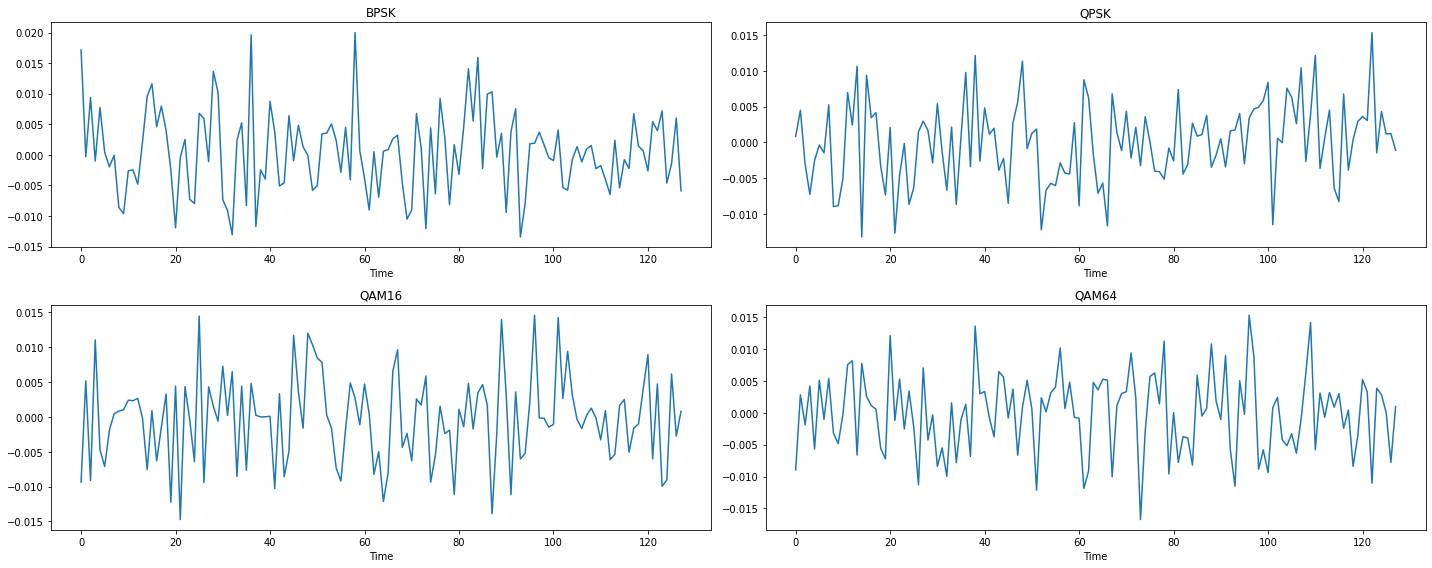

In [136]:
# plot of samples of the four modulation we are investegating 
def signal_plotter(signal_numbers, complex_component):
    n = len(signal_numbers)
    time = [x for x in range(128)]

    # Subplots 
    fig, axs = plt.subplots(2, 2, figsize=(20, 8))
    axs = axs.flatten()

    for i in range(n):
        signal_number = list(signal_numbers.values())[i]

        # Plot on the ith subplot
        axs[i].plot(time, list(X[signal_number][complex_component]))
        axs[i].set_title(f'{list(signal_numbers.keys())[i]}')
        axs[i].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

signal_numbers = {"BPSK":240000, "QPSK": 960000, "QAM16": 720000, "QAM64": 840000} 
complex_component = {"Real":0, "Imaginary":1}
signal_plotter(signal_numbers, complex_component['Real'])

### Split Dataset into (Train, Validate, and Test)

In [137]:
# Create a new array that have the desired modulation schemes to be investegated
X_new = np.zeros(((480000, 2, 128)))
lbl_new = []
mods_new = ['BPSK', 'QPSK', 'QAM16', 'QAM64']

j = 0
for i in range(len(X)):
    if (lbl[i][0] == 'BPSK') or (lbl[i][0] == 'QPSK') or (lbl[i][0] == 'QAM16') or (lbl[i][0] == 'QAM64'):
        lbl_new.append(lbl[i])
        X_new[j] =  X[i]
        j+=1 

X_new.shape

(480000, 2, 128)

In [138]:
# Split the dataset to train, test, Code was taken but adjusted from this source: https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb 

# Set a random seed for reproducibility
np.random.seed(2016)
n_examples = X_new.shape[0]
n_train = int(n_examples * 0.6)  # Set the number of training samples to 60% of the total data
n_valid = int(n_examples * 0.2)  # Set the number of validation samples to 20% of the total data
n_test = n_examples - n_train - n_valid  # The rest (20%) for testing

# Random choice of training, validation, and testing indices 
all_indices = np.arange(n_examples)
np.random.shuffle(all_indices)

train_idx = all_indices[:n_train]
valid_idx = all_indices[n_train:n_train + n_valid]
test_idx = all_indices[n_train + n_valid:]

X_train = X[train_idx]
X_valid = X[valid_idx]
X_test = X[test_idx]

In [139]:
# Perform one-hot encoding for classes
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods_new.index(lbl_new[x][0]), train_idx)))
Y_valid = to_onehot(list(map(lambda x: mods_new.index(lbl_new[x][0]), valid_idx)))
Y_test = to_onehot(list(map(lambda x: mods_new.index(lbl_new[x][0]), test_idx)))

In [140]:
# Taking only partial of the data due to limited computing resources we have in our disposal
X_train_HMM = X_train[80000:180000]
X_train = X_train[:80000]
X_valid = X_valid[:10000]
X_test = X_test[:30000]

Y_train_HMM = Y_train[80000:180000]
Y_train = Y_train[:80000]
Y_valid = Y_valid[:10000]
Y_test = Y_test[:30000] 

### Data Preprocessing

#### Marov Chain Analysis

In [144]:
# Appending the classes of all input to their respective modulation
BPSK = []
QPSK = []
QAM16 = [] 
QAM64 = []
All_mods = [BPSK, QPSK, QAM16, QAM64]
clasees_1 = ['BPSK', 'QPSK', 'QAM16', 'QAM64']

j = 0
for i in train_idx[80000:180000]:
    if lbl_new[i][0] == 'BPSK':
        BPSK.append(X_train_HMM[j])
        j += 1
    elif lbl_new[i][0] == 'QPSK':
        QPSK.append(X_train_HMM[j])
        j += 1
    elif lbl_new[i][0] == 'QAM16':
        QAM16.append(X_train_HMM[j])
        j += 1
    elif lbl_new[i][0] == 'QAM64':
        QAM64.append(X_train_HMM[j])
        j += 1

for i in range(len(All_mods)):
    print(f"Number of signals of {clasees_1[i]} modulation shcemes is: {len(All_mods[i])}")

Number of signals of BPSK modulation shcemes is: 25045
Number of signals of QPSK modulation shcemes is: 25167
Number of signals of QAM16 modulation shcemes is: 24923
Number of signals of QAM64 modulation shcemes is: 24865


In [20]:
from hmmlearn import hmm
# Dictionary for the number of states of every modulation
marov_dict = {"BPSK": 12,  "QPSK": 15, "QAM16": 20, "QAM64": 35}

# BPSK: starting point of 12 is resonable given that it is binary and there is 20 SNRs ratios
# QPSK: starting point of 15 is resonable given that it is quadrature and there is 20 SNRs ratios
# QAM16: it uses 16 different symbols and different SNRs levels are present; starting point of 30 is resonable. However, due to limited computing resources, we opted to reduce the number
# QAM64: it uses 64 different symbols; starting point of 70 is resonable. However, due to limited computing resources, we opted to reduce the number


# Reshaping the dataset to be suitable for the hmm model
All_mods_reshaped = [np.nan_to_num(np.array(mod).reshape(-1, 1)) for mod in All_mods]

# Run the Hiden Marcov model and store the output for each moodulation shceme to a lists called models1
models1 = []
for modulation, n_components in marov_dict.items():
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=50, tol=0.01, verbose=True)
    
    data = All_mods_reshaped[i]
    model.fit(data)
    models1.append(model)

         1 15778301.21647166             +nan
         2 23439647.03439359 +7661345.81792193
         3 23518490.47875984  +78843.44436625
         4 23806045.55429148 +287555.07553164
         5 24086123.17770731 +280077.62341583
         6 24217188.44125238 +131065.26354507
         7 24280655.43800363  +63466.99675125
         8 24319260.49915443  +38605.06115080
         9 24349612.81093989  +30352.31178547
        10 24379856.19677437  +30243.38583448
        11 24415099.53795756  +35243.34118319
        12 24461897.91504603  +46798.37708848
        13 24540903.24168181  +79005.32663578
        14 24689166.46683054 +148263.22514873
        15 24824685.82119788 +135519.35436734
        16 24924285.84016114  +99600.01896326
        17 25024196.27057837  +99910.43041723
        18 25125810.53802409 +101614.26744572
        19 25220504.84515234  +94694.30712825
        20 25307144.13500749  +86639.28985515
        21 25388689.92055790  +81545.78555042
        22 25468001.20486433  +79

In [23]:
# Preparing the training set
X_train_processed = np.zeros((len(X_train), 3, 128))
j = 0

# Loop over all training examples and concatenate a new feature based on Marov hidden satates prediction of the four investegated modulation schemes
for x in X_train:
    max_log_likelihood = float("-inf")

    for model in models1:
        log_likelihood = model.score(x)
        if log_likelihood > max_log_likelihood:
            max_log_likelihood = log_likelihood
            selected_model = model

    X_train_processed[j] =  np.concatenate((x, np.tile(selected_model.transmat_.flatten()[:128], 1).reshape(1, -1)), axis=0)
    j+=1 

In [24]:
# Preparing the validation set
X_valid_processed = np.zeros((len(X_valid), 3, 128))
j = 0

# Loop over all validation examples and concatenate a new feature based on Marov hidden satates prediction of the four investegated modulation schemes
for x in X_valid:
    max_log_likelihood = float("-inf")

    for model in models1:
        log_likelihood = model.score(x)
        if log_likelihood > max_log_likelihood:
            max_log_likelihood = log_likelihood
            selected_model = model

    X_valid_processed[j] =  np.concatenate((x, np.tile(selected_model.transmat_.flatten()[:128], 1).reshape(1, -1)), axis=0)
    j+=1 

In [ ]:
# Preparing the testing set
X_test_processed = np.zeros((len(X_test), 3, 128))
j = 0

# Loop over all testing examples and concatenate a new feature based on Marov hidden satates prediction of the four investegated modulation schemes
for x in X_test:
    max_log_likelihood = float("-inf")

    for model in models1:
        log_likelihood = model.score(x)
        if log_likelihood > max_log_likelihood:
            max_log_likelihood = log_likelihood
            selected_model = model

    X_test_processed[j] =  np.concatenate((x, np.tile(selected_model.transmat_.flatten()[:128], 1).reshape(1, -1)), axis=0)
    j+=1 

#### Stationarrity analysis

In [110]:
# A function to do the augmented Dickey-Fuller test
def adf_test(series):
    result = sm.tsa.adfuller(series, autolag='AIC')
    return result[1]  

# Used as a counter to count the number of stationary & non stationary signals in our training datasets
stationary_count = 0
non_stationary_count = 0

# Analyze stationarity for each signal of the training dataset
for signal_index in range(X_train.shape[0]):  
    for component in range(2):  
        series = X_train[signal_index, component, :]
        p_value = adf_test(series)
        
        if p_value < 0.05:
            stationary_count += 1
        else:
            non_stationary_count += 1

print(f"Total number of stationary series is: {stationary_count}")
print(f"Total number of Non-stationary series is: {non_stationary_count}")

Total number of stationary series is: 132121
Total number of Non-stationary series is: 27879


### Models

#### Basic CNN Model

##### CNN With preprocessed featuures

In [94]:
# Implemnttation of a basic CNN model. Code was taken but adjusted from this source: https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb 
import keras.models as models
in_shp = list(X_train_processed.shape[1:])
classes = mods_new

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_26 (Reshape)        (None, 1, 3, 128)         0         
                                                                 
 zero_padding2d_26 (ZeroPadd  (None, 1, 7, 128)        0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 1, 3, 256)         33024     
                                                                 
 dropout_39 (Dropout)        (None, 1, 3, 256)         0         
                                                                 
 zero_padding2d_27 (ZeroPadd  (None, 1, 7, 256)        0         
 ing2D)                                                          
                                                                 
 conv2 (Conv2D)              (None, 1, 3, 80)        

In [95]:
nb_epoch = 800  # number of epochs 
batch_size = 100 

filepath = 'CNN2_processed.wts.h5' # To save the model parameters
history = model.fit(X_train_processed,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid_processed, Y_valid),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

model.load_weights(filepath)

Epoch 1/800
800/800 - 3s - loss: 1.1426 - val_loss: 1.0316 - 3s/epoch - 3ms/step
Epoch 2/800
800/800 - 3s - loss: 1.0264 - val_loss: 0.9597 - 3s/epoch - 3ms/step
Epoch 3/800
800/800 - 3s - loss: 0.9874 - val_loss: 0.9329 - 3s/epoch - 3ms/step
Epoch 4/800
800/800 - 3s - loss: 0.9631 - val_loss: 0.9048 - 3s/epoch - 3ms/step
Epoch 5/800
800/800 - 3s - loss: 0.9432 - val_loss: 0.8855 - 3s/epoch - 3ms/step
Epoch 6/800
800/800 - 3s - loss: 0.9318 - val_loss: 0.8803 - 3s/epoch - 3ms/step
Epoch 7/800
800/800 - 4s - loss: 0.9247 - val_loss: 0.8902 - 4s/epoch - 5ms/step
Epoch 8/800
800/800 - 3s - loss: 0.9170 - val_loss: 0.8875 - 3s/epoch - 4ms/step
Epoch 9/800
800/800 - 2s - loss: 0.9100 - val_loss: 0.8711 - 2s/epoch - 3ms/step
Epoch 10/800
800/800 - 2s - loss: 0.9079 - val_loss: 0.8674 - 2s/epoch - 3ms/step
Epoch 11/800
800/800 - 3s - loss: 0.9013 - val_loss: 0.8576 - 3s/epoch - 3ms/step
Epoch 12/800
800/800 - 2s - loss: 0.8957 - val_loss: 0.8599 - 2s/epoch - 3ms/step
Epoch 13/800
800/800 - 2s

In [96]:
# Show the loss of the model
score = model.evaluate(X_valid_processed, Y_valid, verbose=0, batch_size=batch_size)
print(f"The loss of basic CNN model with preprocessed featurees is: {score}") 

The loss of basic CNN model with preprocessed featurees is: 0.8287277221679688


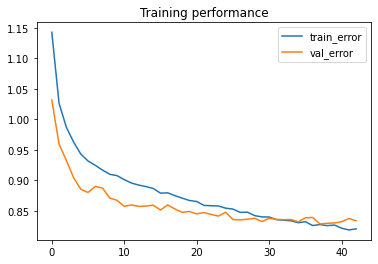

In [97]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train_error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show() 

100/100 [==============================] - 0s 2ms/step


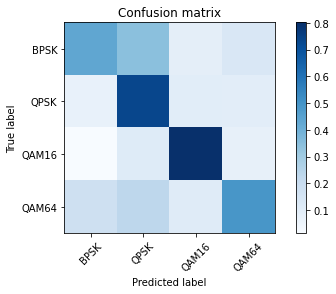

In [98]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
valid_Y_hat = model.predict(X_valid_processed, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_valid_processed.shape[0]):
    j = list(Y_valid[i,:]).index(1)
    k = int(np.argmax(valid_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

##### CNN With raw featuures

In [104]:
# Implemnttation of a basic CNN model. Code was taken but adjusted from this source: https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb 
import keras.models as models
in_shp = list(X_train.shape[1:])
classes = mods_new

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_30 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_30 (ZeroPadd  (None, 1, 6, 128)        0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 1, 2, 256)         33024     
                                                                 
 dropout_45 (Dropout)        (None, 1, 2, 256)         0         
                                                                 
 zero_padding2d_31 (ZeroPadd  (None, 1, 6, 256)        0         
 ing2D)                                                          
                                                                 
 conv2 (Conv2D)              (None, 1, 2, 80)        

In [105]:
nb_epoch = 800  # number of epochs to train on
batch_size = 100  

filepath = 'CNN2_raw.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, Y_valid),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

model.load_weights(filepath)

Epoch 1/800
800/800 - 3s - loss: 1.1495 - val_loss: 1.0358 - 3s/epoch - 3ms/step
Epoch 2/800
800/800 - 3s - loss: 1.0272 - val_loss: 0.9495 - 3s/epoch - 3ms/step
Epoch 3/800
800/800 - 3s - loss: 0.9827 - val_loss: 0.9242 - 3s/epoch - 4ms/step
Epoch 4/800
800/800 - 2s - loss: 0.9554 - val_loss: 0.8915 - 2s/epoch - 2ms/step
Epoch 5/800
800/800 - 2s - loss: 0.9355 - val_loss: 0.8792 - 2s/epoch - 3ms/step
Epoch 6/800
800/800 - 2s - loss: 0.9227 - val_loss: 0.8719 - 2s/epoch - 2ms/step
Epoch 7/800
800/800 - 2s - loss: 0.9145 - val_loss: 0.8707 - 2s/epoch - 3ms/step
Epoch 8/800
800/800 - 2s - loss: 0.9081 - val_loss: 0.8655 - 2s/epoch - 3ms/step
Epoch 9/800
800/800 - 2s - loss: 0.9022 - val_loss: 0.8723 - 2s/epoch - 3ms/step
Epoch 10/800
800/800 - 2s - loss: 0.8986 - val_loss: 0.8564 - 2s/epoch - 2ms/step
Epoch 11/800
800/800 - 2s - loss: 0.8920 - val_loss: 0.8627 - 2s/epoch - 3ms/step
Epoch 12/800
800/800 - 2s - loss: 0.8883 - val_loss: 0.8512 - 2s/epoch - 2ms/step
Epoch 13/800
800/800 - 2s

In [106]:
# Show the loss of the model
score = model.evaluate(X_valid, Y_valid, verbose=0, batch_size=batch_size)
print(f"The loss of basic CNN model with raw featurees is: {score}") 

The loss of basic CNN model with raw featurees is: 0.8208293914794922


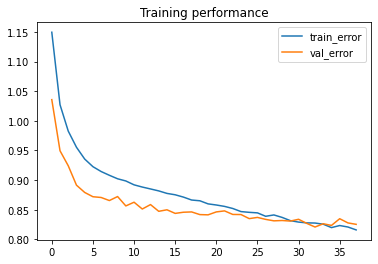

In [107]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train_error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend() 
plt.show() 

100/100 [==============================] - 0s 1ms/step


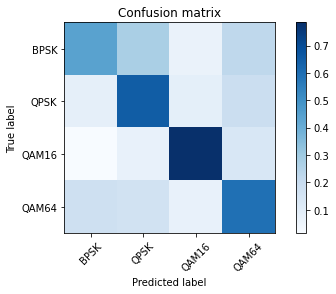

In [108]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
valid_Y_hat = model.predict(X_valid, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_valid.shape[0]):
    j = list(Y_valid[i,:]).index(1)
    k = int(np.argmax(valid_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

#### CNN-LSTM

##### CNN-LSTM With processed featuures

In [111]:
from keras.layers import LSTM

in_shp = list(X_train_processed.shape[1:])
classes = mods_new

dr = 0.5 # Dropout rate
model = Sequential()
model.add(Reshape([1] + in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, (1, 3), padding='valid', activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, (1, 3), padding='valid', activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Reshape((-1, 80)))  
model.add(LSTM(50, activation='relu', return_sequences=True))   # LSTM layer
model.add(LSTM(50, activation='relu'))  # LSTM layer
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense(len(classes), kernel_initializer='he_normal'))
model.add(Activation('softmax'))

# Compile the model & show summary
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_32 (Reshape)        (None, 1, 3, 128)         0         
                                                                 
 zero_padding2d_32 (ZeroPadd  (None, 1, 7, 128)        0         
 ing2D)                                                          
                                                                 
 conv2d (Conv2D)             (None, 1, 5, 256)         98560     
                                                                 
 dropout_48 (Dropout)        (None, 1, 5, 256)         0         
                                                                 
 zero_padding2d_33 (ZeroPadd  (None, 1, 9, 256)        0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 7, 80)        

In [112]:
nb_epoch = 800 # number of epochs 
batch_size = 100

filepath = 'CNN_processed_LSTM_model.wts.h5'
history = model.fit(X_train_processed, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, validation_data=(X_valid_processed, Y_valid), callbacks=[
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
])

model.load_weights(filepath)

Epoch 1/800
800/800 - 12s - loss: 1.1328 - val_loss: 1.0287 - 12s/epoch - 15ms/step
Epoch 2/800
800/800 - 15s - loss: 1.0339 - val_loss: 0.9857 - 15s/epoch - 19ms/step
Epoch 3/800
800/800 - 13s - loss: 0.9520 - val_loss: 0.9090 - 13s/epoch - 16ms/step
Epoch 4/800
800/800 - 14s - loss: 0.9093 - val_loss: 0.8501 - 14s/epoch - 18ms/step
Epoch 5/800
800/800 - 15s - loss: 0.8883 - val_loss: 0.8370 - 15s/epoch - 18ms/step
Epoch 6/800
800/800 - 15s - loss: 0.8733 - val_loss: 0.8368 - 15s/epoch - 19ms/step
Epoch 7/800
800/800 - 16s - loss: 0.8616 - val_loss: 0.8032 - 16s/epoch - 20ms/step
Epoch 8/800
800/800 - 14s - loss: 0.8442 - val_loss: 0.8112 - 14s/epoch - 17ms/step
Epoch 9/800
800/800 - 12s - loss: 0.8253 - val_loss: 0.7705 - 12s/epoch - 15ms/step
Epoch 10/800
800/800 - 12s - loss: 0.8113 - val_loss: 0.7644 - 12s/epoch - 14ms/step
Epoch 11/800
800/800 - 12s - loss: 0.7974 - val_loss: 0.7549 - 12s/epoch - 14ms/step
Epoch 12/800
800/800 - 11s - loss: 0.7875 - val_loss: 0.7464 - 11s/epoch -

In [116]:
# Show the loss of the model
score = model.evaluate(X_valid_processed, Y_valid, verbose=0, batch_size=batch_size)
print(f"The loss of CNN-LSTM model with preprocessed featurees is: {score}") 

The loss of CNN-LSTM model with preprocessed featurees is: 0.7188625931739807


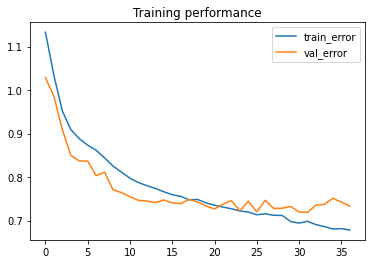

In [117]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train_error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show() 

 10/100 [==>...........................] - ETA: 0s100/100 [==============================] - 1s 6ms/step


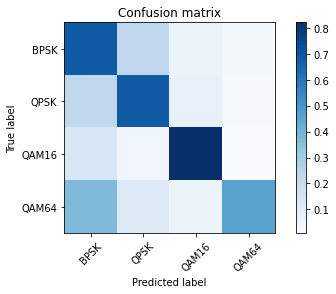

In [118]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
valid_Y_hat = model.predict(X_valid_processed, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_valid_processed.shape[0]):
    j = list(Y_valid[i,:]).index(1)
    k = int(np.argmax(valid_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

##### CNN-LSTM With raw featuures

In [119]:
in_shp = list(X_train.shape[1:])
classes = mods_new


dr = 0.5    # Dropout rate
model = Sequential()
model.add(Reshape([1] + in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, (1, 3), padding='valid', activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, (1, 3), padding='valid', activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Reshape((-1, 80)))  # Reshape output for LSTM, -1 will infer the correct dimension
model.add(LSTM(50, activation='relu', return_sequences=True))   # LSTM layer
model.add(LSTM(50, activation='relu'))  # LSTM layer
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense(len(classes), kernel_initializer='he_normal'))
model.add(Activation('softmax'))

# Compile the model & show summary
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_34 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_34 (ZeroPadd  (None, 1, 6, 128)        0         
 ing2D)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 4, 256)         98560     
                                                                 
 dropout_51 (Dropout)        (None, 1, 4, 256)         0         
                                                                 
 zero_padding2d_35 (ZeroPadd  (None, 1, 8, 256)        0         
 ing2D)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 6, 80)        

In [120]:
nb_epoch = 800 # number of epochs 
batch_size = 100

filepath = 'CNN_raw_LSTM_model.wts.h5'
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=2, validation_data=(X_valid, Y_valid), callbacks=[
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
])

model.load_weights(filepath)

Epoch 1/800
800/800 - 15s - loss: 1.0799 - val_loss: 1.0135 - 15s/epoch - 18ms/step
Epoch 2/800
800/800 - 12s - loss: 1.0057 - val_loss: 0.9903 - 12s/epoch - 15ms/step
Epoch 3/800
800/800 - 12s - loss: 0.9571 - val_loss: 0.8984 - 12s/epoch - 15ms/step
Epoch 4/800
800/800 - 13s - loss: 0.8848 - val_loss: 0.8163 - 13s/epoch - 17ms/step
Epoch 5/800
800/800 - 14s - loss: 0.8261 - val_loss: 0.7697 - 14s/epoch - 17ms/step
Epoch 6/800
800/800 - 12s - loss: 0.7886 - val_loss: 0.7401 - 12s/epoch - 15ms/step
Epoch 7/800
800/800 - 14s - loss: 0.7637 - val_loss: 0.7232 - 14s/epoch - 17ms/step
Epoch 8/800
800/800 - 10s - loss: 0.7451 - val_loss: 0.7145 - 10s/epoch - 12ms/step
Epoch 9/800
800/800 - 10s - loss: 0.7276 - val_loss: 0.7226 - 10s/epoch - 12ms/step
Epoch 10/800
800/800 - 10s - loss: 0.7111 - val_loss: 0.6845 - 10s/epoch - 13ms/step
Epoch 11/800
800/800 - 10s - loss: 0.6966 - val_loss: 0.6936 - 10s/epoch - 13ms/step
Epoch 12/800
800/800 - 12s - loss: 0.6816 - val_loss: 0.6693 - 12s/epoch -

In [122]:
# Show the loss of the model
score = model.evaluate(X_valid, Y_valid, verbose=0, batch_size=batch_size)
print(f"The loss of CNN-LSTM model with raw featurees is: {score}") 

The loss of CNN-LSTM model with raw featurees is: 0.6272848844528198


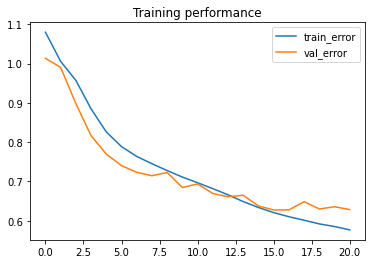

In [123]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train_error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.show() 

100/100 [==============================] - 1s 4ms/step


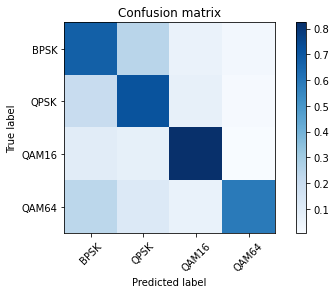

In [124]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
valid_Y_hat = model.predict(X_valid, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_valid_processed.shape[0]):
    j = list(Y_valid[i,:]).index(1)
    k = int(np.argmax(valid_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

#### Random Forest Classifier

##### With processed features

In [130]:
# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf.fit(X_train_processed.reshape(X_trian_processed.shape[0], -1), Y_train)

In [ ]:
# Prediction
predictions = rf.predict(X_valid_processed.reshape(X_valid_processed[0], -1))

# Accuracy
accuracy = accuracy_score(Y_valid, predictions)
print(f"Accuracy: {accuracy}") 

##### without preprocessed features

In [ ]:
# Define the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf.fit(X_train.reshape(X_trian.shape[0], -1), Y_train)

In [ ]:
# Prediction
predictions = rf.predict(X_valid.reshape(X_valid[0], -1))

# Accuracy
accuracy = accuracy_score(Y_valid, predictions)
print(f"Accuracy: {accuracy}") 